In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('cv_server_data.csv')

# Initial Exploratory Data Analysis (EDA)
print("Initial DataFrame Info:")
print(df.info())
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

# Handling missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# Since there are no missing values, we proceed to handle outliers

# Normalizing features
scaler = StandardScaler()
df[['15.79', '14.921']] = scaler.fit_transform(df[['15.79', '14.921']])
print("\nFirst 5 rows after normalization:")
print(df.head())

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   15.79   306 non-null    float64
 1   14.921  306 non-null    float64
dtypes: float64(2)
memory usage: 4.9 KB
None

First 5 rows of the DataFrame:
    15.79  14.921
0  13.640  15.330
1  14.866  16.474
2  13.585  13.989
3  13.464  15.635
4  12.949  16.140

Checking for missing values:
15.79     0
14.921    0
dtype: int64

First 5 rows after normalization:
      15.79    14.921
0 -0.235484  0.228533
1  0.537466  1.124225
2 -0.270159 -0.821400
3 -0.346446  0.467332
4 -0.671135  0.862721



Anomalies detected using Z-score:
        15.79    14.921   z_score  anomaly_z_score  anomaly_iso_forest  \
299  3.326640 -3.415307  3.326640             True                True   
300 -3.325643  1.376334  3.325643             True                True   
301 -8.640874 -7.552874  8.640874             True                True   
302  9.159698  5.137616  9.159698             True                True   
303  3.165872 -2.355978  3.165872             True                True   
305 -3.300739  1.293342  3.300739             True                True   

     anomaly_oc_svm  
299            True  
300            True  
301            True  
302            True  
303            True  
305            True  

Anomalies detected using Isolation Forest:
        15.79    14.921   z_score  anomaly_z_score  anomaly_iso_forest  \
7   -1.319252 -0.573206  1.319252            False                True   
10   1.101101  0.074292  1.101101            False                True   
12  -1.202616 -1.261417  1

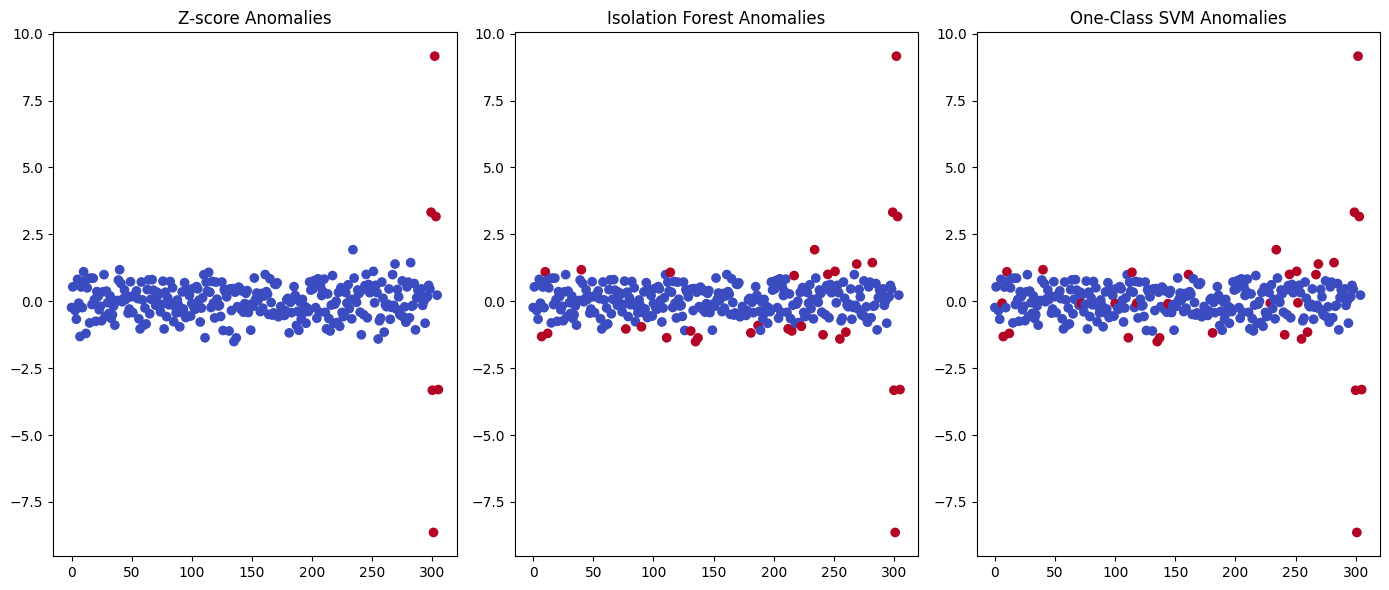

In [5]:
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt

# Z-score for univariate anomaly detection
df['z_score'] = np.abs(stats.zscore(df['15.79']))
df['anomaly_z_score'] = df['z_score'] > 3

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1)
df['anomaly_iso_forest'] = iso_forest.fit_predict(df[['15.79']])
df['anomaly_iso_forest'] = df['anomaly_iso_forest'] == -1

# One-Class SVM
oc_svm = OneClassSVM(nu=0.1)
df['anomaly_oc_svm'] = oc_svm.fit_predict(df[['15.79']])
df['anomaly_oc_svm'] = df['anomaly_oc_svm'] == -1

# Display the results
print("\nAnomalies detected using Z-score:")
print(df[df['anomaly_z_score']])

print("\nAnomalies detected using Isolation Forest:")
print(df[df['anomaly_iso_forest']])

print("\nAnomalies detected using One-Class SVM:")
print(df[df['anomaly_oc_svm']])

# Plotting the anomalies
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.scatter(df.index, df['15.79'], c=df['anomaly_z_score'], cmap='coolwarm')
plt.title('Z-score Anomalies')

plt.subplot(1, 3, 2)
plt.scatter(df.index, df['15.79'], c=df['anomaly_iso_forest'], cmap='coolwarm')
plt.title('Isolation Forest Anomalies')

plt.subplot(1, 3, 3)
plt.scatter(df.index, df['15.79'], c=df['anomaly_oc_svm'], cmap='coolwarm')
plt.title('One-Class SVM Anomalies')

plt.tight_layout()
plt.show()


Isolation Forest - Precision: 0.6363636363636364, Recall: 0.6363636363636364, F1-score: 0.6363636363636364
One-Class SVM - Precision: 0.4666666666666667, Recall: 0.6363636363636364, F1-score: 0.5384615384615384


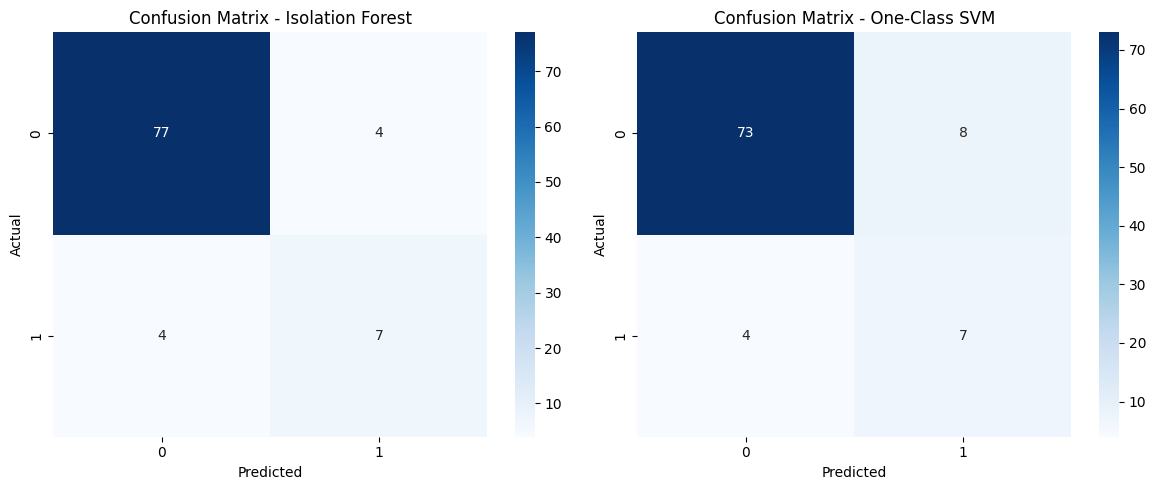

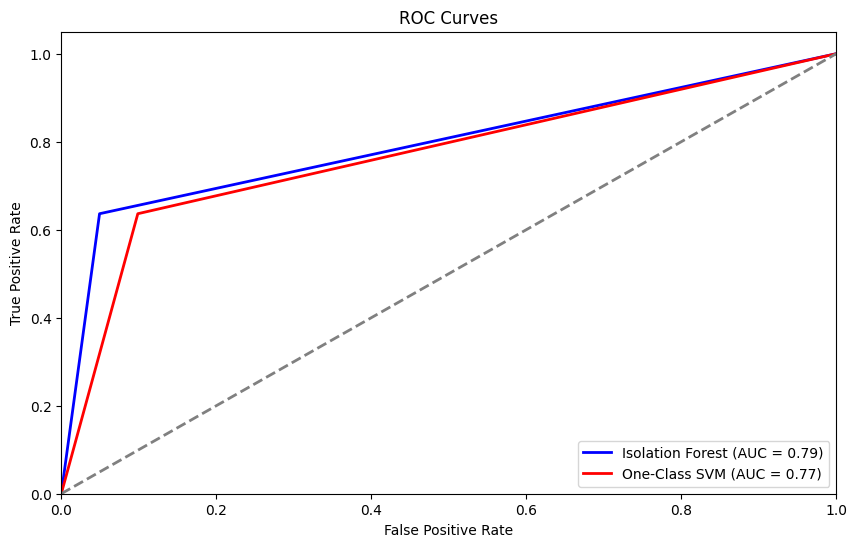

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['15.79', '14.921']], df['anomaly_iso_forest'], test_size=0.3, random_state=42)

# Train the models on the training set
iso_forest.fit(X_train)
oc_svm.fit(X_train)

# Predict on the testing set
y_pred_iso_forest = iso_forest.predict(X_test) == -1
y_pred_oc_svm = oc_svm.predict(X_test) == -1

# Evaluate the performance of the models
precision_iso_forest = precision_score(y_test, y_pred_iso_forest)
recall_iso_forest = recall_score(y_test, y_pred_iso_forest)
f1_iso_forest = f1_score(y_test, y_pred_iso_forest)

precision_oc_svm = precision_score(y_test, y_pred_oc_svm)
recall_oc_svm = recall_score(y_test, y_pred_oc_svm)
f1_oc_svm = f1_score(y_test, y_pred_oc_svm)

print(f"Isolation Forest - Precision: {precision_iso_forest}, Recall: {recall_iso_forest}, F1-score: {f1_iso_forest}")
print(f"One-Class SVM - Precision: {precision_oc_svm}, Recall: {recall_oc_svm}, F1-score: {f1_oc_svm}")

# Confusion matrices
conf_matrix_iso_forest = confusion_matrix(y_test, y_pred_iso_forest)
conf_matrix_oc_svm = confusion_matrix(y_test, y_pred_oc_svm)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)            
sns.heatmap(conf_matrix_iso_forest, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_oc_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - One-Class SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC curves
fpr_iso_forest, tpr_iso_forest, _ = roc_curve(y_test, y_pred_iso_forest)
roc_auc_iso_forest = auc(fpr_iso_forest, tpr_iso_forest)

fpr_oc_svm, tpr_oc_svm, _ = roc_curve(y_test, y_pred_oc_svm)
roc_auc_oc_svm = auc(fpr_oc_svm, tpr_oc_svm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_iso_forest, tpr_iso_forest, color='blue', lw=2, label=f'Isolation Forest (AUC = {roc_auc_iso_forest:.2f})')
plt.plot(fpr_oc_svm, tpr_oc_svm, color='red', lw=2, label=f'One-Class SVM (AUC = {roc_auc_oc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

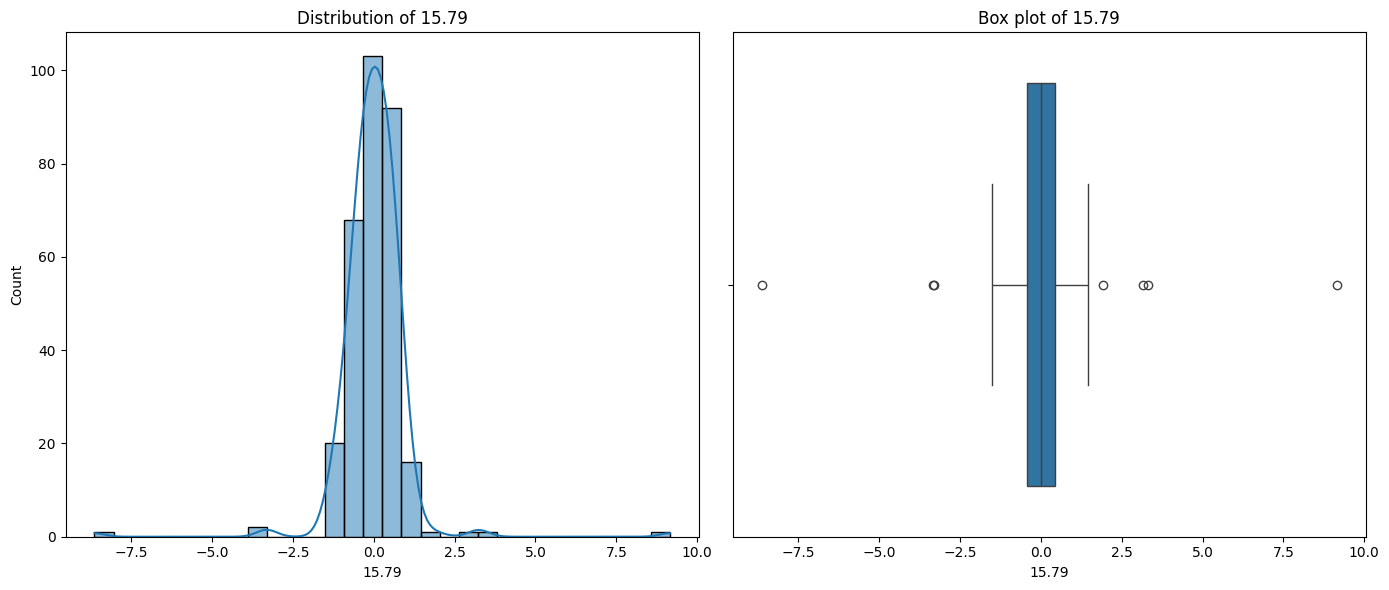

<Figure size 1400x600 with 0 Axes>

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of the '15.79' and '14.921' features
plt.figure(figsize=(14, 6))

# Distribution plot for '15.79'
plt.subplot(1, 2, 1)
sns.histplot(df['15.79'], kde=True, bins=30)
plt.title('Distribution of 15.79')

# Box plot to show outliers for '15.79'
plt.subplot(1, 2, 2)
sns.boxplot(x=df['15.79'])
plt.title('Box plot of 15.79')

plt.tight_layout()
plt.show()

# Visualize the detected anomalies
plt.figure(figsize=(14, 6))



plt.tight_layout()
plt.show()
